# LLE

## Выполнил Курузов Илья

In [50]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter

from scipy.sparse.linalg import eigsh
from scipy.sparse import csr_matrix

import cvxpy as cvx

from sklearn import datasets

In [3]:
matplotlib.use('Agg')
params = {'legend.fontsize': 20,
          'legend.handlelength': 4,
          "axes.labelsize": 45,
          "xtick.labelsize": 25,
          "ytick.labelsize": 25,
          "lines.linewidth": 4,
           "axes.titlesize":30}
matplotlib.rcParams.update(params)

Метод для получения весов оптимальной линейной комбинации. На вход получает матрицу исходных данных $X\in\mathbb{R}^{m\times n}$ из $m$ точек из пространства $\mathbb{R}^n$, коэффициент $\ell_2$-регуляризации $\lambda\geq 0$ и размер окрестрности $K\in\mathbb{N}$. Решает $m$ задач оптимизации при помощи пакета ${\tt cvxpy}$ вида

$$\min_{\mathbf{w}\in\mathbb{R}^K} \|\mathbf{x}_j - \mathbf{w}\tilde{X} \|^2_2$$
где $\tilde{X}\in\mathbb{K\times n}$ - матрица $K$ ближайших соседей $j$-ой точки для $j=\overline{1,m}$. Далее матрица нормируется таким образом, что сумма элементов каждой строчки была равна единице.

In [304]:
def get_w(X, lamda=1e-8, K=None):
    if K is None:
        K = np.infty
    m = X.shape[0]
    W = np.zeros((m, m))
    for i in range(m):
        w = cvx.Variable(K)
        d = np.array([np.linalg.norm(X[i] - x) for x in X])
        ind = np.argsort(d)[1:K+1]
        X_ = X[ind]
        obj = cvx.norm(X[i] - w @ X_)**2 + lamda * cvx.norm(w)**2
        problem = cvx.Problem(cvx.Minimize(obj))
        problem.solve()
        W[i, ind] = w.value / w.value.sum()
    return W

Восстановим $d$-мерное многообразие на основе матрицы $W\in\mathbb{R}^{m\times m}$ с предыдущего шага, используя собственные вектора $M=(I_m-W)^\top (I_m-W)$.

In [305]:
def get_y(W, d=2):
    W = np.eye(W.shape[0]) - W
    M = W.T @ W
    u, V = np.linalg.eigh(M)
    ind = np.argsort(u)[1:d+1]
    Y = V[:, ind]
    return Y

In [306]:
def LLE(X, lamda=1e-8, d=2, K=5):
    W = get_w(X, lamda=lamda, K=K)
    Y = get_y(W, d=d)
    return Y

Визуализируем S-датасет.

In [307]:
n_points = 1000
X, color = datasets.make_s_curve(n_points, random_state=0)

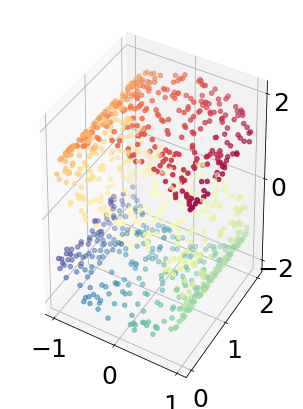

In [308]:
fig = plt.figure(figsize=(30, 16))
ax = fig.add_subplot(251, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=plt.cm.Spectral)

In [309]:
Y = LLE(X, lamda=1e-3, K=5)

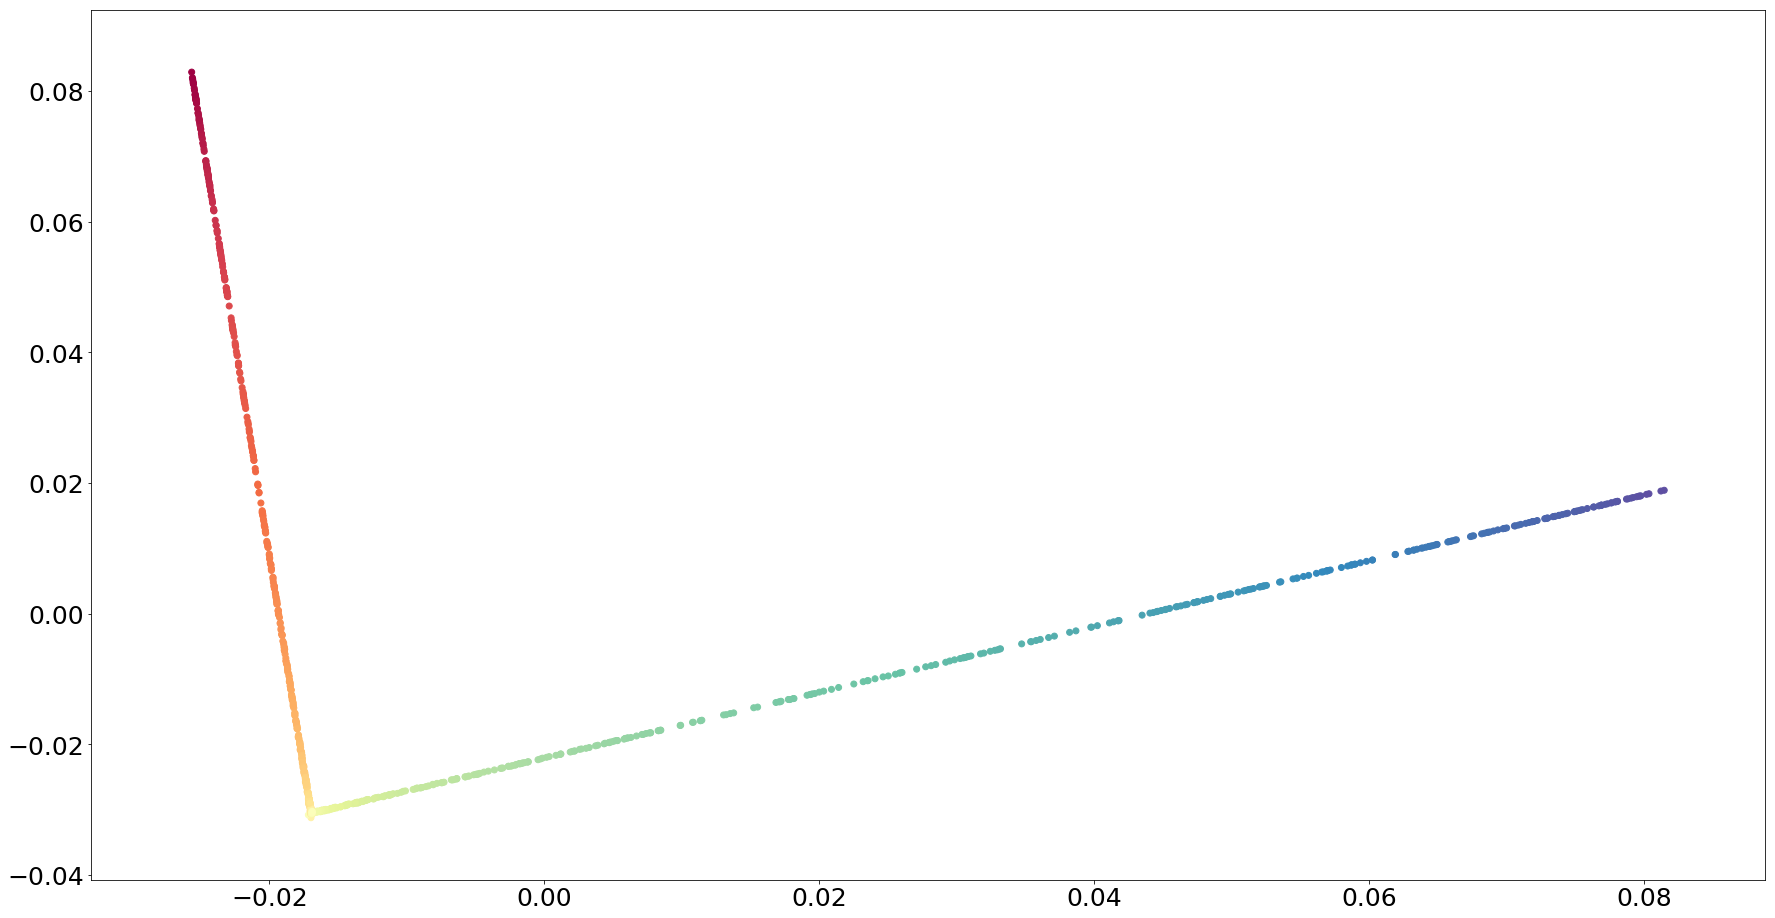

In [312]:
%matplotlib inline
plt.subplots(figsize=(30, 16))
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)

Можно видеть, что S развернулась в угол.